In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import os
import shutil
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf


In [ ]:
from keras.utils import plot_model
from imblearn.over_sampling import SMOTE
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization, Conv2D, Conv2DTranspose, Dense, Dropout, Flatten, GlobalAveragePooling2D, Input, MaxPooling2D
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, roc_auc_score
from tensorflow.keras.applications import ResNet50V2, VGG16, InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img,img_to_array

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pathlib
folder = '/content/drive/MyDrive/BreaKHis_v1/histology_slides/breast'
folder_path = pathlib.Path(folder)

In [ ]:
img_path = "./BreaKHis_v1/"
classes = ["benign","malign"]

In [ ]:
import os
os.getcwd()

'/content'

In [ ]:
fold_df = pd.read_csv("/content/drive/MyDrive/BreaKHis_v1/Folds.csv")

In [ ]:
fold_df = fold_df.rename(columns = {"filename":"path"})
#Printing the head of the file
fold_df.head(3)

fold  mag    grp                                               path
0     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...
1     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...
2     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...

In [ ]:
#One example path is printed
fold_df['path'][1]

'BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-002.png'

In [ ]:
#Extracting the filename and label from the path column
fold_df['filename'] = fold_df['path'].apply(lambda x:x.split("/")[-1])
fold_df["label"] = fold_df['path'].apply(lambda x: x.split("/")[3])

In [ ]:
fold_df.head(3)

fold  mag    grp                                               path  \
0     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   
1     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   
2     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   

                         filename   label  
0  SOB_B_A-14-22549AB-100-001.png  benign  
1  SOB_B_A-14-22549AB-100-002.png  benign  
2  SOB_B_A-14-22549AB-100-003.png  benign

In [ ]:
#Creating new directory
# os.rmdir("../Cancer/")
os.makedirs("../Cancer/")

In [ ]:
for p in fold_df['path']:
    src = "/content/drive/MyDrive/" + p
    dest = "../Cancer/"
    #saving the files with its corresponding class and patient_id
    dest = os.path.join(dest,src.split("/")[7]+ "_" + src.split("/")[-1])
    shutil.copyfile(src,dest)

In [ ]:
#Checking the len
len(os.listdir("../Cancer/"))

7909

In [ ]:
#Creating a new data frame with labels and file names stored in single folder
fold_df['file_loc'] = fold_df['label'] + "_" + fold_df['filename']
#Encoding the class to integer
fold_df['class'] = fold_df['label'].apply(lambda x: 0 if x =='benign' else 1)

In [ ]:
#Printing the head to display the changed made
fold_df.head(3)

fold  mag    grp                                               path  \
0     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   
1     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   
2     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   

                         filename   label  \
0  SOB_B_A-14-22549AB-100-001.png  benign   
1  SOB_B_A-14-22549AB-100-002.png  benign   
2  SOB_B_A-14-22549AB-100-003.png  benign   

                                file_loc  class  
0  benign_SOB_B_A-14-22549AB-100-001.png      0  
1  benign_SOB_B_A-14-22549AB-100-002.png      0  
2  benign_SOB_B_A-14-22549AB-100-003.png      0

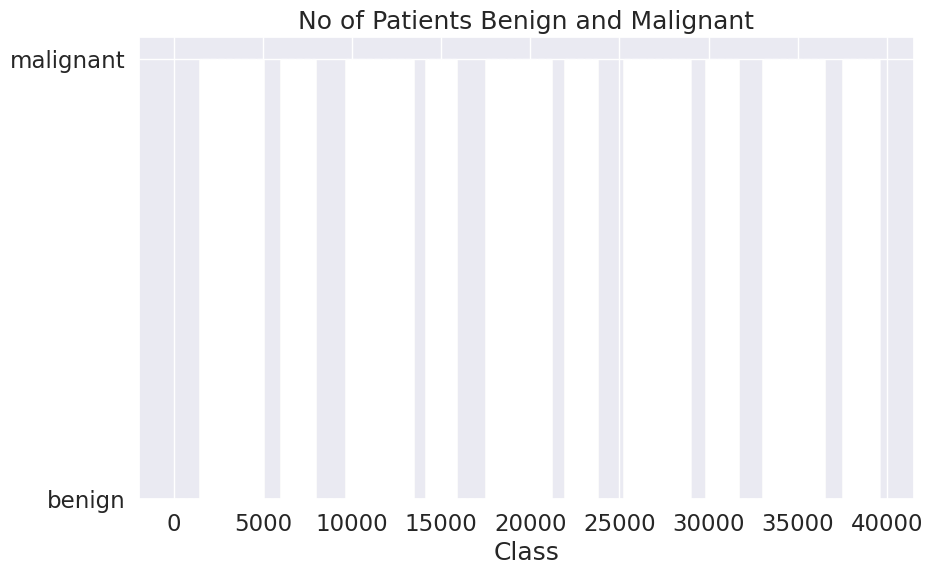

In [ ]:
#Lets explore the data set
plt.figure(figsize=(10,6))
sns.set(font_scale = 1.5)
# sns.set_style("darkgrid")
# sns.countplot(fold_df['label']);
plt.bar(range(len(fold_df)), fold_df['label'])
plt.xlabel("Class")
plt.title("No of Patients Benign and Malignant");

In [ ]:
#Filtering the data frame to benign and malignant for visualization
benign_df = fold_df[fold_df['label'] == 'benign']
malignant_df = fold_df[fold_df['label'] == 'malignant']

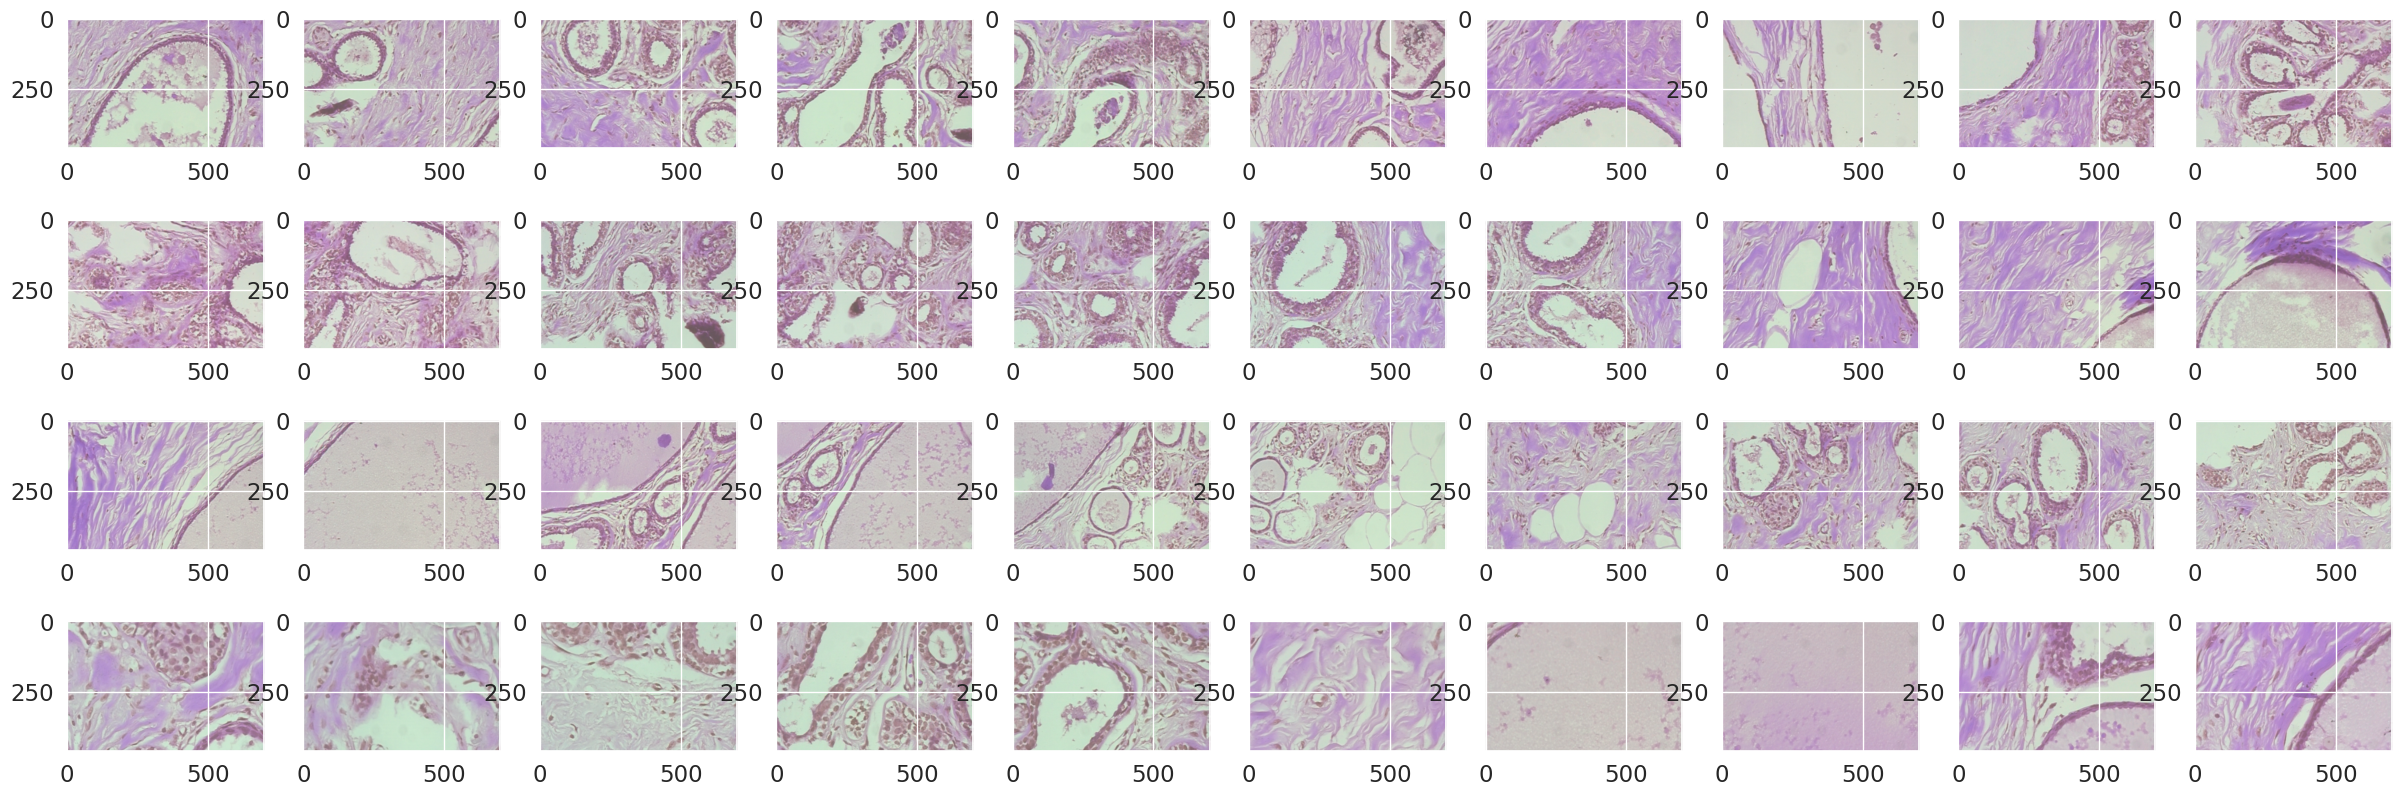

In [ ]:
#Plotting the benign samples
plt.figure(figsize = (30,10))
for i in range(0,40):
    plt.subplot(4,10,i+1)
    img = cv2.imread("../Cancer/"+ benign_df['file_loc'][i],1)
    plt.imshow(img)

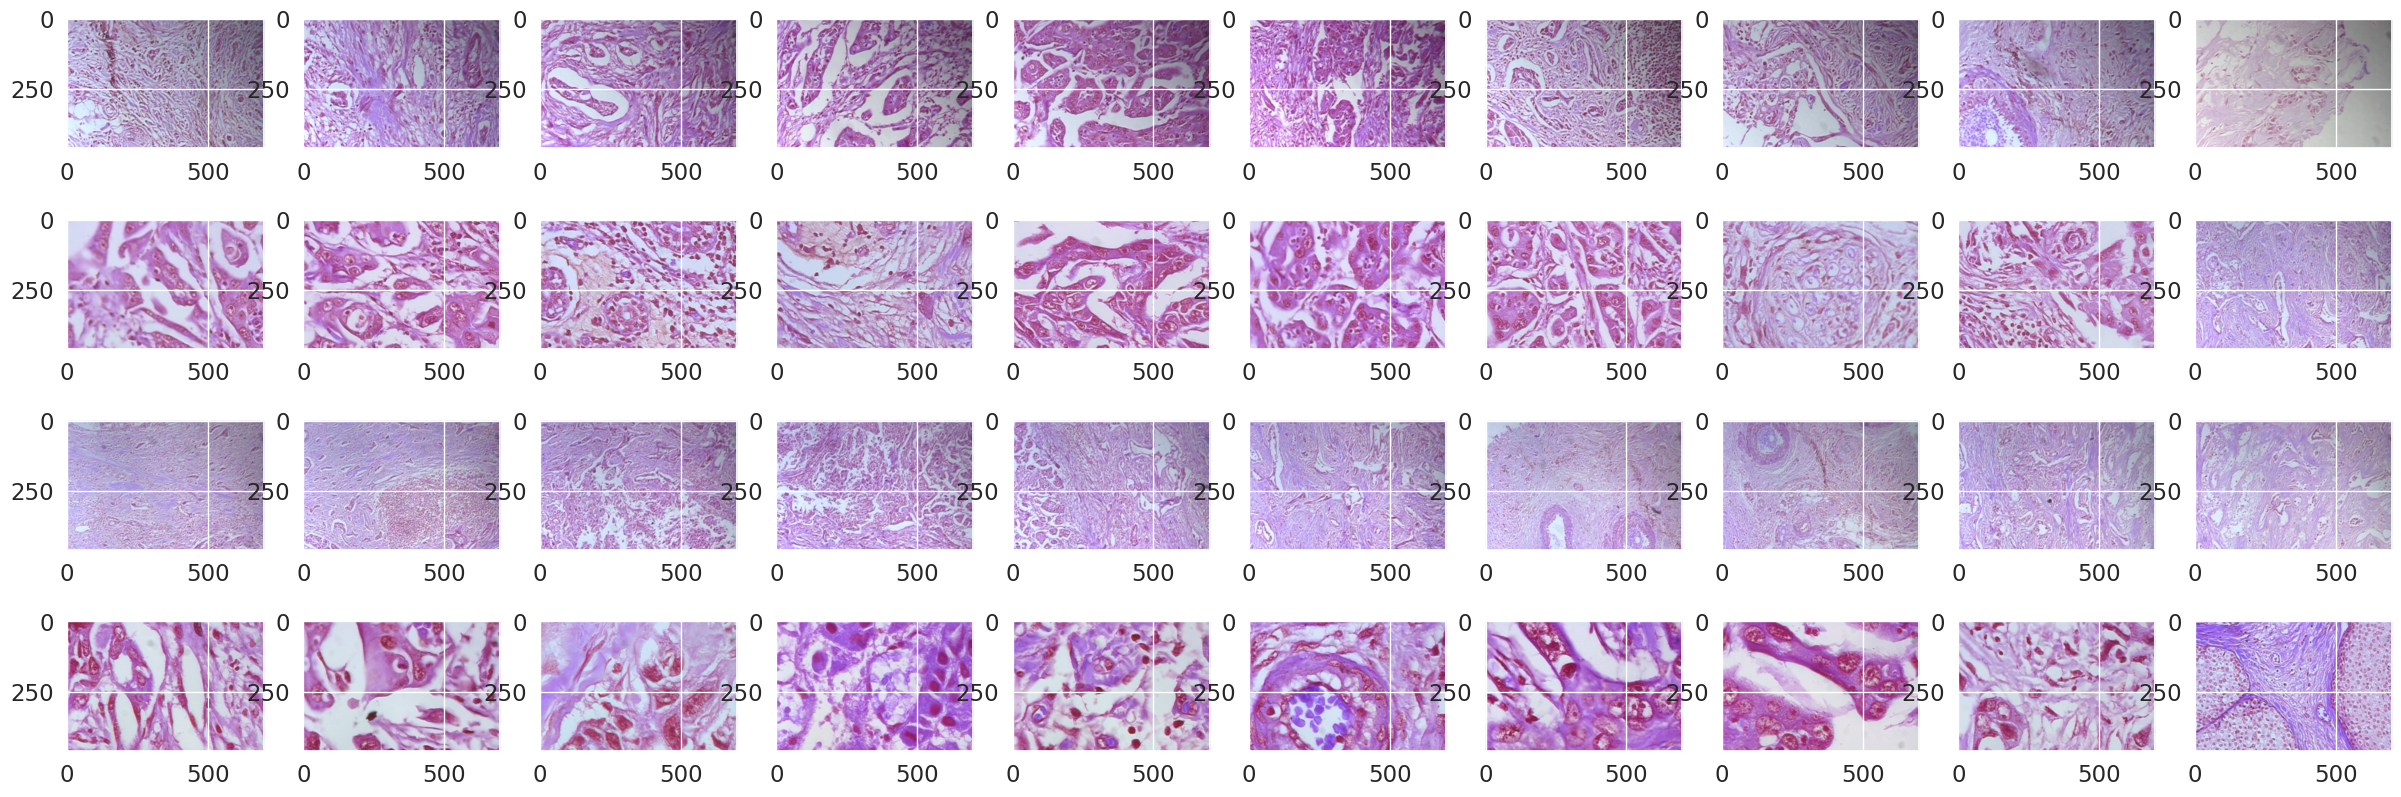

In [ ]:
#Plotting the malignant samples
images = malignant_df['file_loc'].values
plt.figure(figsize = (30,10))
for i in range(0,40):
    plt.subplot(4,10,i+1)
    img = cv2.imread("../Cancer/"+ images[i],1)
    plt.imshow(img)

In [ ]:
#Creating a new data frame with the file loc as its index, label and class of the patients as its columns.
df = pd.DataFrame(os.listdir("../Cancer/"))
df = df.rename(columns = {0:'file_loc'})
df['label'] = df['file_loc'].apply(lambda x:x.split("_")[0])
df['class'] = df['label'].apply(lambda x: 0 if x =='benign' else 1)
df.set_index("file_loc",inplace=True)

In [ ]:
#Checking the data frame
df.head(2)

label  class
file_loc                                                 
benign_SOB_B_TA-14-3411F-100-017.png        benign      0
malignant_SOB_M_PC-14-19440-200-010.png  malignant      1

In [ ]:
#Performing the splitting
data_train_and_val, data_test = train_test_split(df, test_size = 0.1, random_state = 47)
#Traing and val
data_train, data_val = train_test_split(data_train_and_val, test_size = 0.1, random_state = 47)

In [ ]:
print("Training size :", data_train.shape)
print("Validation size :", data_val.shape)
print("Testing size :", data_test.shape)

Training size : (6406, 2)
Validation size : (712, 2)
Testing size : (791, 2)


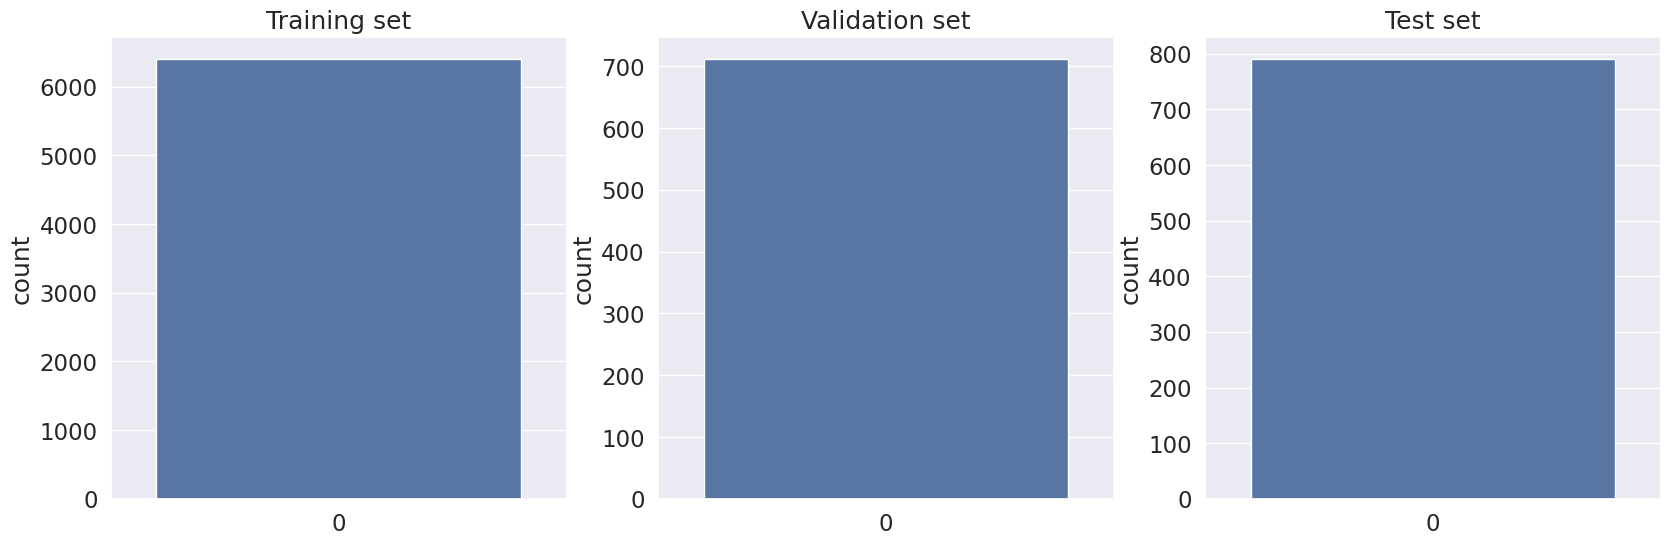

In [ ]:
#Plotting
sns.set_style("darkgrid")
plt.figure(figsize = (20,6))
plt.subplot(1,3,1)
sns.countplot(data_train['class'])
plt.title("Training set")
plt.subplot(1,3,2)
sns.countplot(data_val['class'])
plt.title("Validation set")
plt.subplot(1,3,3)
sns.countplot(data_test['class']);
plt.title("Test set");

In [ ]:
#Separating the benign and malignant patients from train data
train_has_cancer = data_train[data_train['class'] == 1]
train_has_no_cancer = data_train[data_train['class'] == 0]

In [ ]:
train_has_cancer.shape

(4398, 2)

In [ ]:
train_has_no_cancer.shape

(2008, 2)

In [ ]:
#Upsampling the minority class by the size of majority class with replacement
train_has_no_cancer_upsample = resample(train_has_no_cancer, n_samples = len(train_has_cancer),
                                     random_state = 47, replace = True)

In [ ]:
#Concatenating the upsampled minority class and the majority class
data_train = pd.concat([train_has_cancer,train_has_no_cancer_upsample])

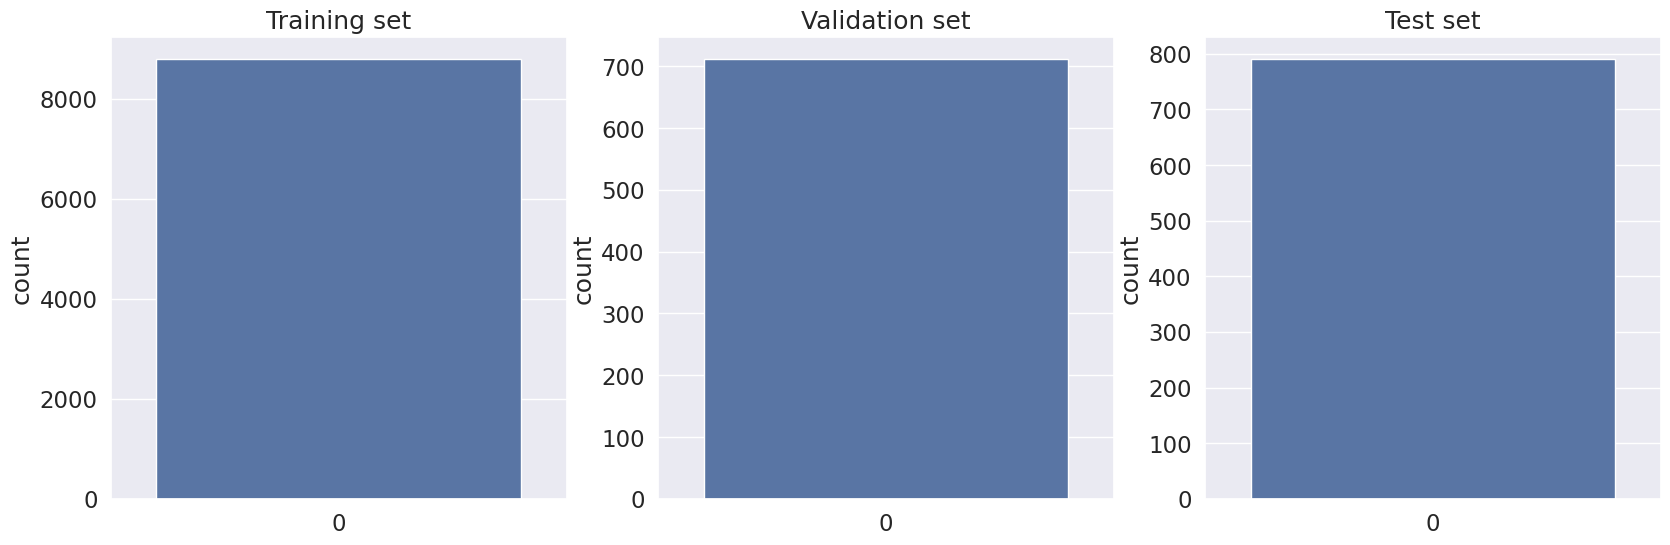

In [ ]:
sns.set_style("darkgrid")
plt.figure(figsize = (20,6))
plt.subplot(1,3,1)
sns.countplot(data_train['class'])
plt.title("Training set")
plt.subplot(1,3,2)
sns.countplot(data_val['class'])
plt.title("Validation set")
plt.subplot(1,3,3)
sns.countplot(data_test['class']);
plt.title("Test set");

In [ ]:
#Creating the directories to store images
os.makedirs("../Cancer_train")
os.makedirs("../Cancer_test")
os.makedirs("../Cancer_validation")
os.makedirs("../Cancer_train/benign")
os.makedirs("../Cancer_train/malignant")
os.makedirs("../Cancer_validation/benign")
os.makedirs("../Cancer_validation/malignant")
os.makedirs("../Cancer_test/benign")
os.makedirs("../Cancer_test/malignant")

In [ ]:
#Training data
i = 1
for img in data_train.index:
    if img!=".DS_Store":
        target = df.loc[img,'class']
        if target == 1:
            label = 'malignant'
        else:
            label = 'benign'
        src = os.path.join("../Cancer/",img)
        dest = os.path.join("../Cancer_train/",label, "image" + str(i)+".png")
        img1 = np.array(cv2.imread(src))
        cv2.imwrite(dest,img1)
        i = i+1

In [ ]:
#Validation data
for img in data_val.index:
    target = data_val.loc[img,'class']
    if target == 1:
        label = 'malignant'
    else:
        label = 'benign'

    src = os.path.join("../Cancer/",img)
    dest = os.path.join("../Cancer_validation/",label,img)
    shutil.copyfile(src,dest)

In [ ]:
#Testing data
for img in data_test.index:
    target = data_test.loc[img,'class']
    if target == 1:
        label = 'malignant'
    else:
        label = 'benign'

    src = os.path.join("../Cancer/",img)
    dest = os.path.join("../Cancer_test/",label,img)
    shutil.copyfile(src,dest)

In [ ]:
#Checking their lengths
print("Training Data:")
print(" ")
print("Benign:",len(os.listdir("../Cancer_train/benign/")))
print("Malignant::",len(os.listdir("../Cancer_train/malignant/")))
print(" ")
print("Validation Data")
print(" ")
print("Benign size:",len(os.listdir("../Cancer_validation/benign/")))
print("Malignant size :",len(os.listdir("../Cancer_validation/malignant/")))
print(" ")
print("Testing Data:")
print(" ")
print("Benign size :",len(os.listdir("../Cancer_test/benign/")))
print("Malignant size :",len(os.listdir("../Cancer_test/malignant/")))

Training Data:
 
Benign: 4398
Malignant:: 4398
 
Validation Data
 
Benign size: 225
Malignant size : 487
 
Testing Data:
 
Benign size : 247
Malignant size : 544


In [ ]:
#Defining Image Data Generator
datagen = ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1./255,
    shear_range=0.2,
    fill_mode='nearest',
    zoom_range=0.2)

In [ ]:
#Setting up the images for image data generator
train_generation = datagen.flow_from_directory("../Cancer_train/",target_size=(128,128),batch_size = 32, class_mode="binary")
val_generation = datagen.flow_from_directory("../Cancer_validation/", target_size=(128,128), batch_size=32, class_mode="binary")

Found 8796 images belonging to 2 classes.
Found 712 images belonging to 2 classes.


In [ ]:
#Defining the base model
cancer_model = Sequential()

#First Layer
cancer_model.add(Conv2D(filters = 32, kernel_size = (3,3), input_shape = (128,128,3), activation = 'relu'))
cancer_model.add(MaxPooling2D(pool_size = (2,2)))

#Second Layer
cancer_model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'same',activation = 'relu'))
cancer_model.add(MaxPooling2D(pool_size = (2,2)))

#Third Layer
cancer_model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'same', activation = 'relu'))
cancer_model.add(MaxPooling2D(pool_size = (2,2)))
cancer_model.add(Dropout(0.4))

#Fourth Layer
cancer_model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = 'same', activation = 'relu'))
cancer_model.add(MaxPooling2D(pool_size = (2,2)))
cancer_model.add(Dropout(0.2))

#Flattening the layers
cancer_model.add(Flatten())

#Adding the dense layer
cancer_model.add(Dense(256, activation = 'relu'))
cancer_model.add(Dense(128, activation = 'relu'))
cancer_model.add(Dense(1, activation = 'sigmoid'))

cancer_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 63, 63, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 31, 31, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 128)      0

In [ ]:
#Setting the learning rate to reduce gradually over the training period
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=20*50,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

In [ ]:
#Compiling the model
cancer_model.compile(loss='binary_crossentropy', optimizer = get_optimizer(), metrics = ['accuracy'])
early_stop = EarlyStopping(monitor='val_loss',patience=5)
checkpoint = ModelCheckpoint("./Best_model/",save_best_only=True,)

In [ ]:
#Model is fitted using train and validation generator for 200 epochs
history = cancer_model.fit(train_generation, validation_data=val_generation, epochs=20 ,
                 callbacks=[early_stop,checkpoint], verbose = 1)

Epoch 1/20
275/275 [==============================] - ETA: 0s - loss: 0.6035 - accuracy: 0.6608

275/275 [==============================] - 560s 2s/step - loss: 0.6035 - accuracy: 0.6608 - val_loss: 0.4431 - val_accuracy: 0.8624
Epoch 2/20
275/275 [==============================] - 565s 2s/step - loss: 0.4926 - accuracy: 0.7801 - val_loss: 0.5598 - val_accuracy: 0.7289
Epoch 3/20
275/275 [==============================] - ETA: 0s - loss: 0.4677 - accuracy: 0.8051

275/275 [==============================] - 583s 2s/step - loss: 0.4677 - accuracy: 0.8051 - val_loss: 0.4095 - val_accuracy: 0.8539
Epoch 4/20
275/275 [==============================] - 545s 2s/step - loss: 0.4601 - accuracy: 0.8073 - val_loss: 0.5246 - val_accuracy: 0.7725
Epoch 5/20
275/275 [==============================] - 570s 2s/step - loss: 0.4416 - accuracy: 0.8141 - val_loss: 0.4425 - val_accuracy: 0.8385
Epoch 6/20
275/275 [==============================] - ETA: 0s - loss: 0.4051 - accuracy: 0.8271

275/275 [==============================] - 555s 2s/step - loss: 0.4051 - accuracy: 0.8271 - val_loss: 0.3470 - val_accuracy: 0.8666
Epoch 7/20
275/275 [==============================] - 562s 2s/step - loss: 0.3901 - accuracy: 0.8303 - val_loss: 0.4127 - val_accuracy: 0.8553
Epoch 8/20
275/275 [==============================] - ETA: 0s - loss: 0.3703 - accuracy: 0.8391

275/275 [==============================] - 566s 2s/step - loss: 0.3703 - accuracy: 0.8391 - val_loss: 0.3376 - val_accuracy: 0.8680
Epoch 9/20
275/275 [==============================] - ETA: 0s - loss: 0.3537 - accuracy: 0.8473

275/275 [==============================] - 557s 2s/step - loss: 0.3537 - accuracy: 0.8473 - val_loss: 0.3135 - val_accuracy: 0.8750
Epoch 10/20
275/275 [==============================] - ETA: 0s - loss: 0.3415 - accuracy: 0.8488

275/275 [==============================] - 572s 2s/step - loss: 0.3415 - accuracy: 0.8488 - val_loss: 0.2978 - val_accuracy: 0.8876
Epoch 11/20
275/275 [==============================] - ETA: 0s - loss: 0.3268 - accuracy: 0.8595

275/275 [==============================] - 567s 2s/step - loss: 0.3268 - accuracy: 0.8595 - val_loss: 0.2901 - val_accuracy: 0.8848
Epoch 12/20
275/275 [==============================] - ETA: 0s - loss: 0.3161 - accuracy: 0.8648

275/275 [==============================] - 568s 2s/step - loss: 0.3161 - accuracy: 0.8648 - val_loss: 0.2559 - val_accuracy: 0.8933
Epoch 13/20
275/275 [==============================] - 569s 2s/step - loss: 0.3034 - accuracy: 0.8709 - val_loss: 0.3219 - val_accuracy: 0.8792
Epoch 14/20
275/275 [==============================] - 554s 2s/step - loss: 0.2946 - accuracy: 0.8720 - val_loss: 0.2791 - val_accuracy: 0.8792
Epoch 15/20
275/275 [==============================] - 588s 2s/step - loss: 0.2868 - accuracy: 0.8809 - val_loss: 0.3049 - val_accuracy: 0.8596
Epoch 16/20
275/275 [==============================] - ETA: 0s - loss: 0.2737 - accuracy: 0.8853

275/275 [==============================] - 568s 2s/step - loss: 0.2737 - accuracy: 0.8853 - val_loss: 0.2541 - val_accuracy: 0.8834
Epoch 17/20
275/275 [==============================] - ETA: 0s - loss: 0.2593 - accuracy: 0.8942

275/275 [==============================] - 551s 2s/step - loss: 0.2593 - accuracy: 0.8942 - val_loss: 0.2411 - val_accuracy: 0.9003
Epoch 18/20
275/275 [==============================] - ETA: 0s - loss: 0.2471 - accuracy: 0.8981

275/275 [==============================] - 534s 2s/step - loss: 0.2471 - accuracy: 0.8981 - val_loss: 0.2373 - val_accuracy: 0.8989
Epoch 19/20
275/275 [==============================] - ETA: 0s - loss: 0.2406 - accuracy: 0.8988

275/275 [==============================] - 553s 2s/step - loss: 0.2406 - accuracy: 0.8988 - val_loss: 0.2263 - val_accuracy: 0.9101
Epoch 20/20
275/275 [==============================] - 534s 2s/step - loss: 0.2333 - accuracy: 0.9076 - val_loss: 0.2431 - val_accuracy: 0.8890


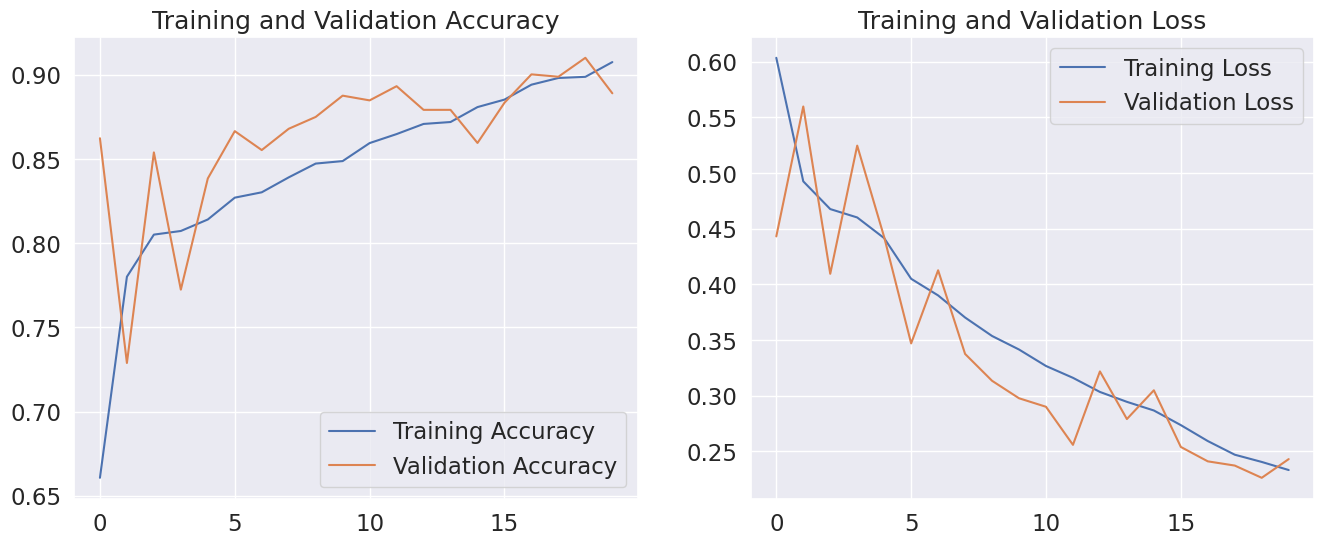

In [ ]:
#Plotting the model results

#Getting the accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

#Getting the losses
loss = history.history['loss']
val_loss = history.history['val_loss']

#No of epochs it trained
epochs_range = history.epoch

#Plotting Training and Validation accuracy
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#Plotting Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
#Loading the test data using Image Data Generator
test_gen = datagen.flow_from_directory("../Cancer_test/", target_size=(128,128), class_mode="binary", batch_size=1, shuffle=False)

Found 791 images belonging to 2 classes.


In [ ]:
pred = cancer_model.evaluate(test_gen)

791/791 [==============================] - 30s 37ms/step - loss: 0.2605 - accuracy: 0.8786


In [ ]:
#Let's Go ahead and test our model for few Images.

#Array to hold Input Images and their labels
test = []
labels = []

#Loading random 10 images
random_images = np.random.choice(data_test.index,10)

#For loop to read and store images
for i in random_images:
    #Finding their class to load from folder
    label = data_test.loc[i,"class"]
    labels.append(label)
    if label == 1:
        lab = "malignant"
    else:
        lab = "benign"
    #Creating path
    path = os.path.join("../Cancer_test/", lab, i)
    #reading image
    img = cv2.imread(path)
    #resizing to target shape
    img = cv2.resize(img,(128,128))
    #Making it an numpy array
    img = np.array(img)
    #Appending it to the list
    test.append(img)

#Making the list as numpy array
test = np.asarray(test)
#rescaling it by pixel value
test = test/255.

In [ ]:
#Performing the prediction
pred = (cancer_model.predict(test) > 0.5).astype("int32")
#Flattening the list to form single dimensional list
pred = pred.flatten()

1/1 [==============================] - 0s 500ms/step


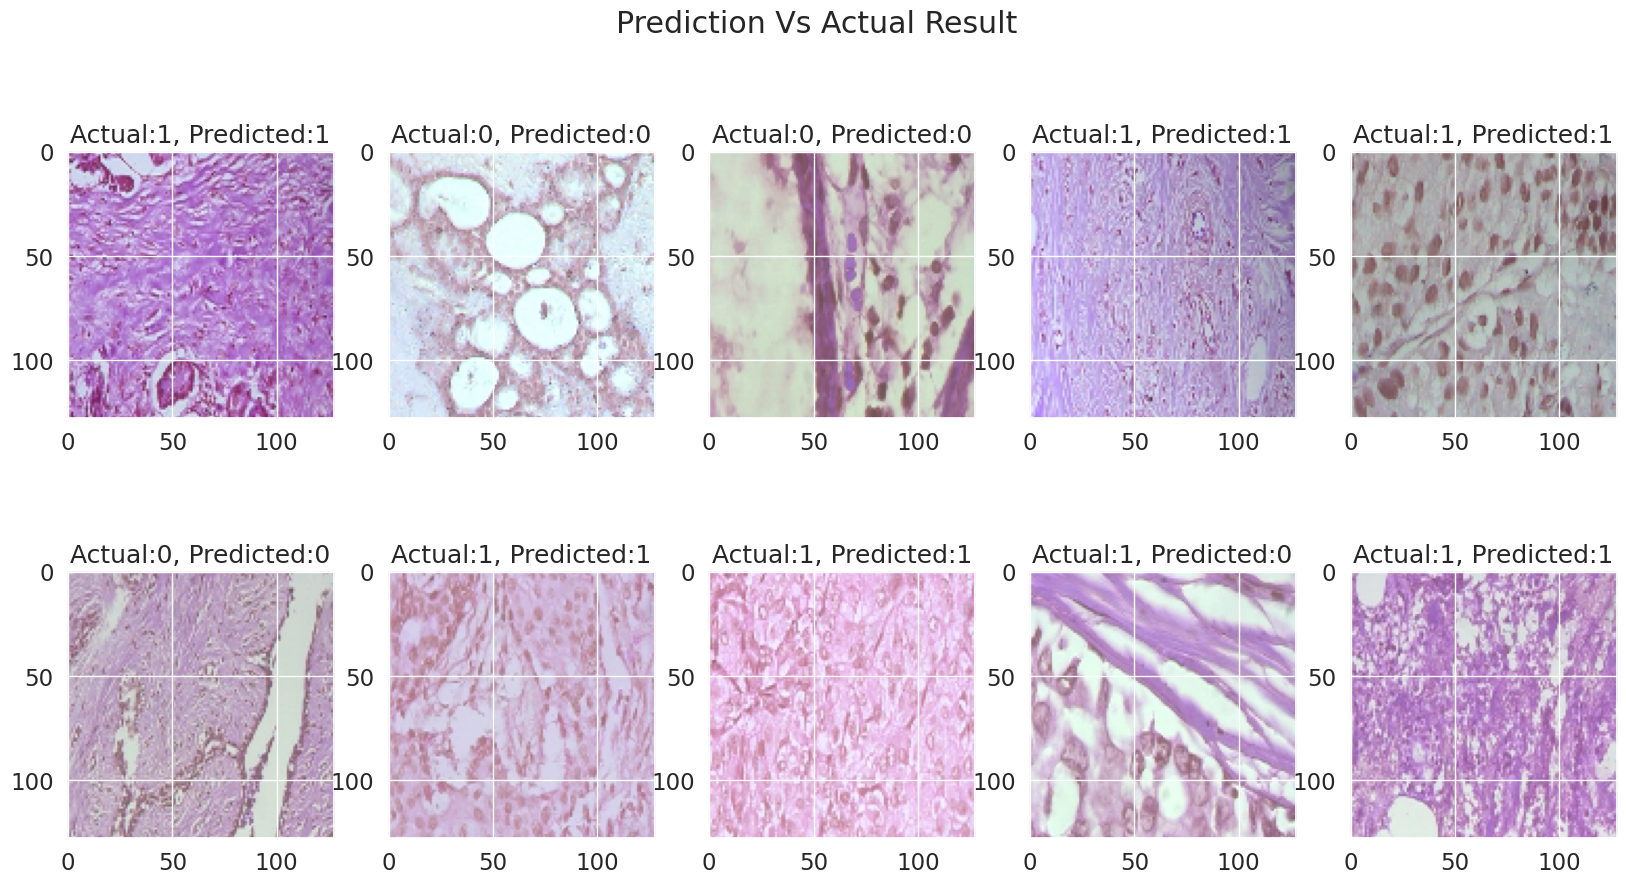

In [ ]:
#Plotting results and actual prediction
plt.figure(figsize=(20,10))
plt.suptitle("Prediction Vs Actual Result")
for i in range(0,10):
    string = "Actual:" + str(labels[i]) + ", Predicted:" + str(pred[i])
    plt.subplot(2,5,i+1)
    plt.imshow(test[i])
    plt.title(string)